# Cleaning Gaze Data During Blinks

During blinks, the eyelid partially or fully covers the pupil, producing gaze samples that
do not reflect actual eye position. These **blink artifacts** corrupt downstream analyses
such as fixation detection, velocity computation, and saccade classification.

This notebook demonstrates how to:

1. Load a real EyeLink dataset with blink events
2. Visualize the raw gaze signal with blink regions highlighted
3. Use `set_event_samples_to_null()` to remove blink artifacts (with optional padding)
4. Visualize the cleaned result, showing which samples were nullified

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

import pymovements as pm

## 1. Load Real EyeLink Data

We use the `ToyDatasetEyeLink` dataset, which contains monocular eye tracking data
recorded at 1000 Hz using an EyeLink Portable Duo.

We first use `Dataset.download()` to fetch the data, then load the `.asc` file
directly with `events=True` so that blink events from `SBLINK`/`EBLINK` markers
are parsed.

In [50]:
from pymovements.gaze.io import from_asc

# Download the dataset
dataset = pm.Dataset('ToyDatasetEyeLink', path='data/ToyDataset')
dataset.download()

# Load the first ASC file with events=True to parse blink events
asc_file = dataset.paths.raw / 'pymovements-toy-dataset-eyelink-main' / 'raw' / 'subject_1_session_1.asc'

gaze = from_asc(
    asc_file,
    patterns='eyelink',
    encoding='ascii',
    events=True,
)

print('Samples shape:', gaze.samples.shape)
print('Columns:', gaze.samples.columns)
gaze.samples.head()

INFO:pymovements.dataset.dataset:
        You are downloading the pymovements Toy Dataset EyeLink. Please be aware that pymovements does not
        host or distribute any dataset resources and only provides a convenient interface to
        download the public dataset resources that were published by their respective authors.

        Please cite the referenced publication if you intend to use the dataset in your research.
        


Using already downloaded and verified file: data\ToyDataset\downloads\pymovements-toy-dataset-eyelink.zip
Extracting pymovements-toy-dataset-eyelink.zip to data\ToyDataset\raw


Extracting archive: 100%|██████████| 4/4 [00:00<00:00, 77.62file/s]


Samples shape: (128342, 3)
Columns: ['time', 'pupil', 'pixel']


time,pupil,pixel
i64,f64,list[f64]
2154556,778.0,"[138.1, 132.8]"
2154557,778.0,"[138.2, 132.7]"
2154558,778.0,"[138.2, 132.3]"
2154559,778.0,"[138.1, 131.9]"
2154560,777.0,"[137.9, 131.6]"


## 2. Inspect Blink Events

EyeLink blink events are stored with the name `blink_eyelink`. Let's look at the
detected blinks and their durations.

In [51]:
# Show all event types in the data
print('Event types:', gaze.events.frame['name'].unique().to_list())

# Filter to blink events only
blink_events = gaze.events.frame.filter(pl.col('name') == 'blink_eyelink')
print(f'\nFound {len(blink_events)} blink events:')
blink_events

Event types: ['saccade_eyelink', 'blink_eyelink', 'fixation_eyelink']

Found 19 blink events:


name,eye,onset,offset,duration
str,str,i64,i64,i64
"""blink_eyelink""","""left""",2157547,2157575,28
"""blink_eyelink""","""left""",2159353,2159404,51
"""blink_eyelink""","""left""",2159486,2159575,89
"""blink_eyelink""","""left""",2165704,2165759,55
"""blink_eyelink""","""left""",2170335,2170391,56
…,…,…,…,…
"""blink_eyelink""","""left""",2205859,2205924,65
"""blink_eyelink""","""left""",2211374,2211443,69
"""blink_eyelink""","""left""",2214206,2214261,55


## 3. Visualize Raw Signal with Blink Regions

We pick a time window that contains a few blinks and plot the raw gaze signal with
blink intervals shaded in gray.

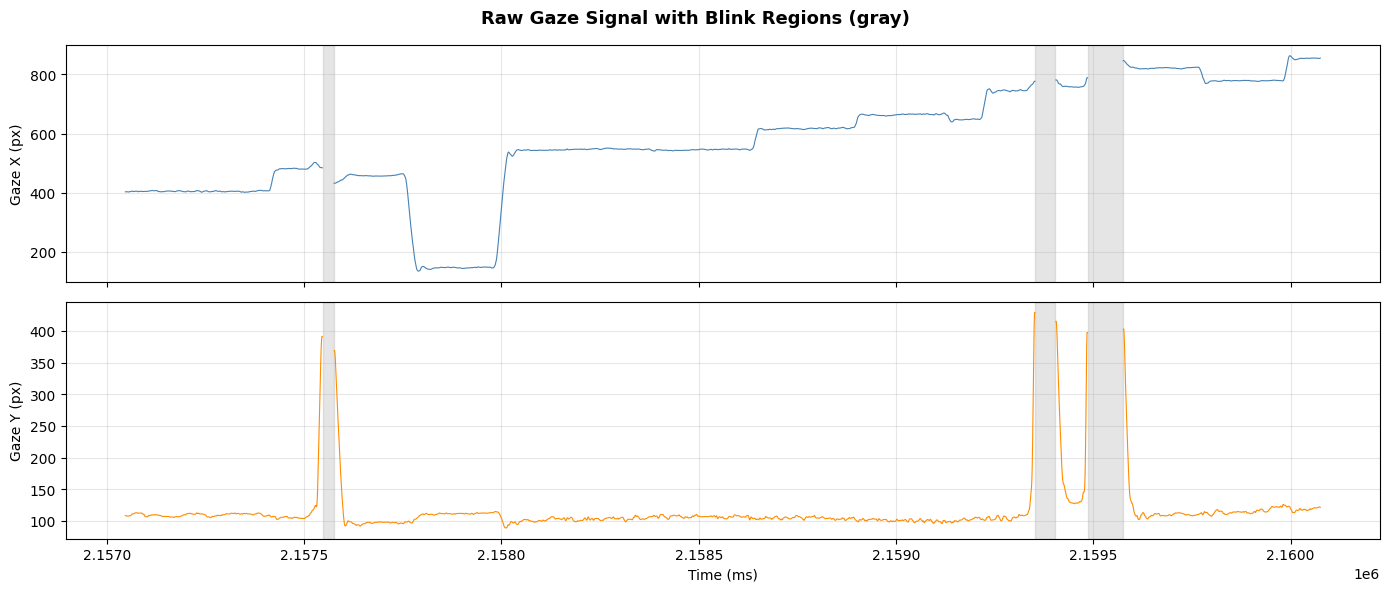

In [52]:
# Extract time, pixel coordinates, and pupil as arrays (before cleaning)
time_arr = gaze.samples['time'].to_numpy()
pixel_data = gaze.samples['pixel'].to_list()
x_raw = np.array([p[0] if p is not None else np.nan for p in pixel_data])
y_raw = np.array([p[1] if p is not None else np.nan for p in pixel_data])
pupil_raw = gaze.samples['pupil'].to_numpy().copy()

# Get blink onset/offset pairs
blink_onsets = blink_events['onset'].to_list()
blink_offsets = blink_events['offset'].to_list()
blink_regions = list(zip(blink_onsets, blink_offsets))

# Focus on a window around the first few blinks
window_start = blink_onsets[0] - 500
window_end = blink_offsets[2] + 500 if len(blink_onsets) > 2 else blink_offsets[-1] + 500
mask = (time_arr >= window_start) & (time_arr <= window_end)

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

for ax, data, label, color in [
    (axes[0], x_raw, 'Gaze X (px)', 'steelblue'),
    (axes[1], y_raw, 'Gaze Y (px)', 'darkorange'),
]:
    ax.plot(time_arr[mask], data[mask], color=color, linewidth=0.8)

    for onset, offset in blink_regions:
        if onset >= window_start and onset <= window_end:
            ax.axvspan(onset, offset, alpha=0.2, color='gray')

    ax.set_ylabel(label)
    ax.grid(True, alpha=0.3)

axes[1].set_xlabel('Time (ms)')
fig.suptitle('Raw Gaze Signal with Blink Regions (gray)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Apply `set_event_samples_to_null()`

We nullify gaze samples during blink events. The `padding` parameter extends the
cleaning window to also remove the unreliable samples immediately before and after
each blink:

- **`padding=10`** means 10 ms of symmetric padding (same before and after)
- **`padding=(20, 10)`** means 20 ms before and 10 ms after (asymmetric)

Asymmetric padding is useful because the onset of a blink (eyelid closing) often
produces artifacts slightly before the detected blink start, while the offset
(eyelid opening) artifacts resolve more quickly.

In [ ]:
# Apply blink cleaning with the default symmetric padding of 25 ms
gaze.set_event_samples_to_null('blink_eyelink')

# Count how many samples were nullified
null_count = gaze.samples['pixel'].null_count()
total = gaze.samples.height

print(f'Nullified {null_count} / {total} samples ({100 * null_count / total:.1f}%)')
print(f'Using default padding: (25, 25) ms')

## 5. Visualize Before vs. After

We plot the same time window again, now showing which samples were nullified (red)
and the cleaned signal with gaps where blink data was removed.

In [ ]:
# Build null mask
null_mask = gaze.samples['pixel'].is_null().to_numpy()

# Extract cleaned coordinates
cleaned_pixels = gaze.samples['pixel'].to_list()
x_cleaned = np.array([p[0] if p is not None else np.nan for p in cleaned_pixels])
y_cleaned = np.array([p[1] if p is not None else np.nan for p in cleaned_pixels])

# Default padding used
padding = (25, 25)

# Compute padded blink regions for shading
padded_regions = [
    (onset - padding[0], offset + padding[1])
    for onset, offset in blink_regions
]

# Plot before vs. after in the same time window
fig, axes = plt.subplots(2, 2, figsize=(16, 7), sharex=True)

for col, (x_data, y_data, label) in enumerate([
    (x_raw, y_raw, 'Before Cleaning'),
    (x_cleaned, y_cleaned, 'After Cleaning'),
]):
    for row, (data, ylabel, color) in enumerate([
        (x_data, 'Gaze X (px)', 'steelblue'),
        (y_data, 'Gaze Y (px)', 'darkorange'),
    ]):
        ax = axes[row, col]
        ax.plot(time_arr[mask], data[mask], color=color, linewidth=0.8)

        for onset, offset in padded_regions:
            if onset >= window_start and onset <= window_end:
                ax.axvspan(onset, offset, alpha=0.12, color='red')

        # On the 'before' panel, mark nullified samples in red
        if col == 0:
            null_in_window = mask & null_mask
            ax.scatter(
                time_arr[null_in_window], data[null_in_window],
                color='red', s=8, zorder=5, label='Nullified',
            )
            ax.legend(loc='upper right', fontsize=8)

        ax.set_ylabel(ylabel)
        ax.set_title(label if row == 0 else '', fontsize=11)
        ax.grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Time (ms)')
axes[1, 1].set_xlabel('Time (ms)')
fig.suptitle('Before vs. After Blink Cleaning', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Pupil Signal During Blinks

The pupil size signal also shows characteristic artifacts during blinks. Let's
visualize the pupil trace alongside the blink regions.

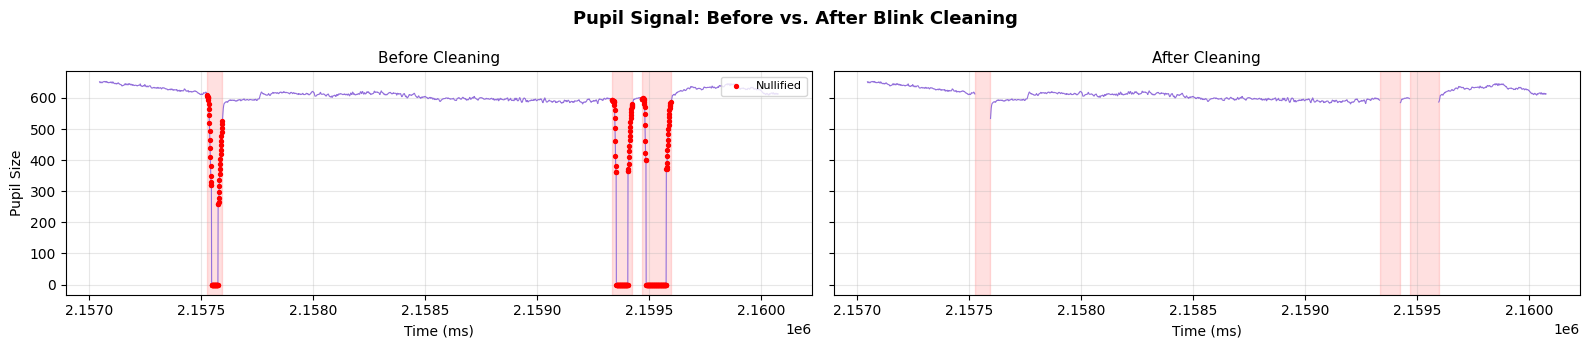

In [59]:
pupil_cleaned = gaze.samples['pupil'].to_numpy()
null_in_window = mask & null_mask

fig, axes = plt.subplots(1, 2, figsize=(16, 3.5), sharex=True, sharey=True)

# Before: original pupil signal with nullified samples marked in red
axes[0].plot(time_arr[mask], pupil_raw[mask], color='mediumpurple', linewidth=0.8)
axes[0].scatter(
    time_arr[null_in_window], pupil_raw[null_in_window],
    color='red', s=8, zorder=5, label='Nullified',
)
for onset, offset in padded_regions:
    if onset >= window_start and onset <= window_end:
        axes[0].axvspan(onset, offset, alpha=0.12, color='red')
axes[0].set_title('Before Cleaning', fontsize=11)
axes[0].set_ylabel('Pupil Size')
axes[0].set_xlabel('Time (ms)')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(True, alpha=0.3)

# After: cleaned pupil signal with gaps
axes[1].plot(time_arr[mask], pupil_cleaned[mask], color='mediumpurple', linewidth=0.8)
for onset, offset in padded_regions:
    if onset >= window_start and onset <= window_end:
        axes[1].axvspan(onset, offset, alpha=0.12, color='red')
axes[1].set_title('After Cleaning', fontsize=11)
axes[1].set_xlabel('Time (ms)')
axes[1].grid(True, alpha=0.3)

fig.suptitle('Pupil Signal: Before vs. After Blink Cleaning', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Summary Statistics

A per-blink summary of the cleaning impact.

In [60]:
summary_rows = []
for row in blink_events.to_dicts():
    onset = row['onset']
    offset = row['offset']
    summary_rows.append({
        'onset': onset,
        'offset': offset,
        'blink_ms': offset - onset,
        'padded_onset': onset - padding[0],
        'padded_offset': offset + padding[1],
        'padded_ms': (offset + padding[1]) - (onset - padding[0]),
    })

summary_df = pl.DataFrame(summary_rows)
print('Blink Cleaning Summary')
print('=' * 60)
print(summary_df)
print(f'\nTotal samples: {total}')
print(f'Total nullified: {null_count} ({100 * null_count / total:.1f}%)')
print(f'Remaining usable: {total - null_count} ({100 * (total - null_count) / total:.1f}%)')

Blink Cleaning Summary
shape: (19, 6)
┌─────────┬─────────┬──────────┬──────────────┬───────────────┬───────────┐
│ onset   ┆ offset  ┆ blink_ms ┆ padded_onset ┆ padded_offset ┆ padded_ms │
│ ---     ┆ ---     ┆ ---      ┆ ---          ┆ ---           ┆ ---       │
│ i64     ┆ i64     ┆ i64      ┆ i64          ┆ i64           ┆ i64       │
╞═════════╪═════════╪══════════╪══════════════╪═══════════════╪═══════════╡
│ 2157547 ┆ 2157575 ┆ 28       ┆ 2157527      ┆ 2157595       ┆ 68        │
│ 2159353 ┆ 2159404 ┆ 51       ┆ 2159333      ┆ 2159424       ┆ 91        │
│ 2159486 ┆ 2159575 ┆ 89       ┆ 2159466      ┆ 2159595       ┆ 129       │
│ 2165704 ┆ 2165759 ┆ 55       ┆ 2165684      ┆ 2165779       ┆ 95        │
│ 2170335 ┆ 2170391 ┆ 56       ┆ 2170315      ┆ 2170411       ┆ 96        │
│ …       ┆ …       ┆ …        ┆ …            ┆ …             ┆ …         │
│ 2205859 ┆ 2205924 ┆ 65       ┆ 2205839      ┆ 2205944       ┆ 105       │
│ 2211374 ┆ 2211443 ┆ 69       ┆ 2211354      ┆ 22

## 8. Apply to All Recordings and Inspect Blink Instances

We clean all recordings, then plot every blink instance (with a window of context
around each) so you can visually verify the cleaning.

In [ ]:
padding_all = (25, 25)  # default
context_ms = 100  # extra ms of context before/after the padded region

# Collect all blink instances across recordings
all_blinks = []

asc_dir = dataset.paths.raw / 'pymovements-toy-dataset-eyelink-main' / 'raw'

for asc_path in sorted(asc_dir.glob('*.asc')):
    gaze_obj = from_asc(
        asc_path,
        patterns='eyelink',
        encoding='ascii',
        events=True,
    )

    blinks = gaze_obj.events.frame.filter(pl.col('name') == 'blink_eyelink')
    n_blinks = len(blinks)

    # Save raw data before cleaning
    t = gaze_obj.samples['time'].to_numpy()
    px = gaze_obj.samples['pixel'].to_list()
    x_before = np.array([p[0] if p is not None else np.nan for p in px])
    y_before = np.array([p[1] if p is not None else np.nan for p in px])
    pupil_before = gaze_obj.samples['pupil'].to_numpy().copy()

    # Apply cleaning with default padding
    gaze_obj.set_event_samples_to_null('blink_eyelink')
    null_mask_all = gaze_obj.samples['pixel'].is_null().to_numpy()

    null_count = null_mask_all.sum()
    total = gaze_obj.samples.height
    print(
        f'{asc_path.name}: {n_blinks} blinks, '
        f'{null_count}/{total} samples nullified ({100 * null_count / total:.1f}%)'
    )

    # Store each blink instance
    for row in blinks.to_dicts():
        onset, offset = row['onset'], row['offset']
        win_start = onset - padding_all[0] - context_ms
        win_end = offset + padding_all[1] + context_ms
        win = (t >= win_start) & (t <= win_end)

        all_blinks.append({
            'file': asc_path.stem,
            'onset': onset,
            'offset': offset,
            'duration': offset - onset,
            'time': t[win],
            'x_raw': x_before[win],
            'y_raw': y_before[win],
            'pupil_raw': pupil_before[win],
            'null_mask': null_mask_all[win],
        })

print(f'\nTotal blink instances collected: {len(all_blinks)}')

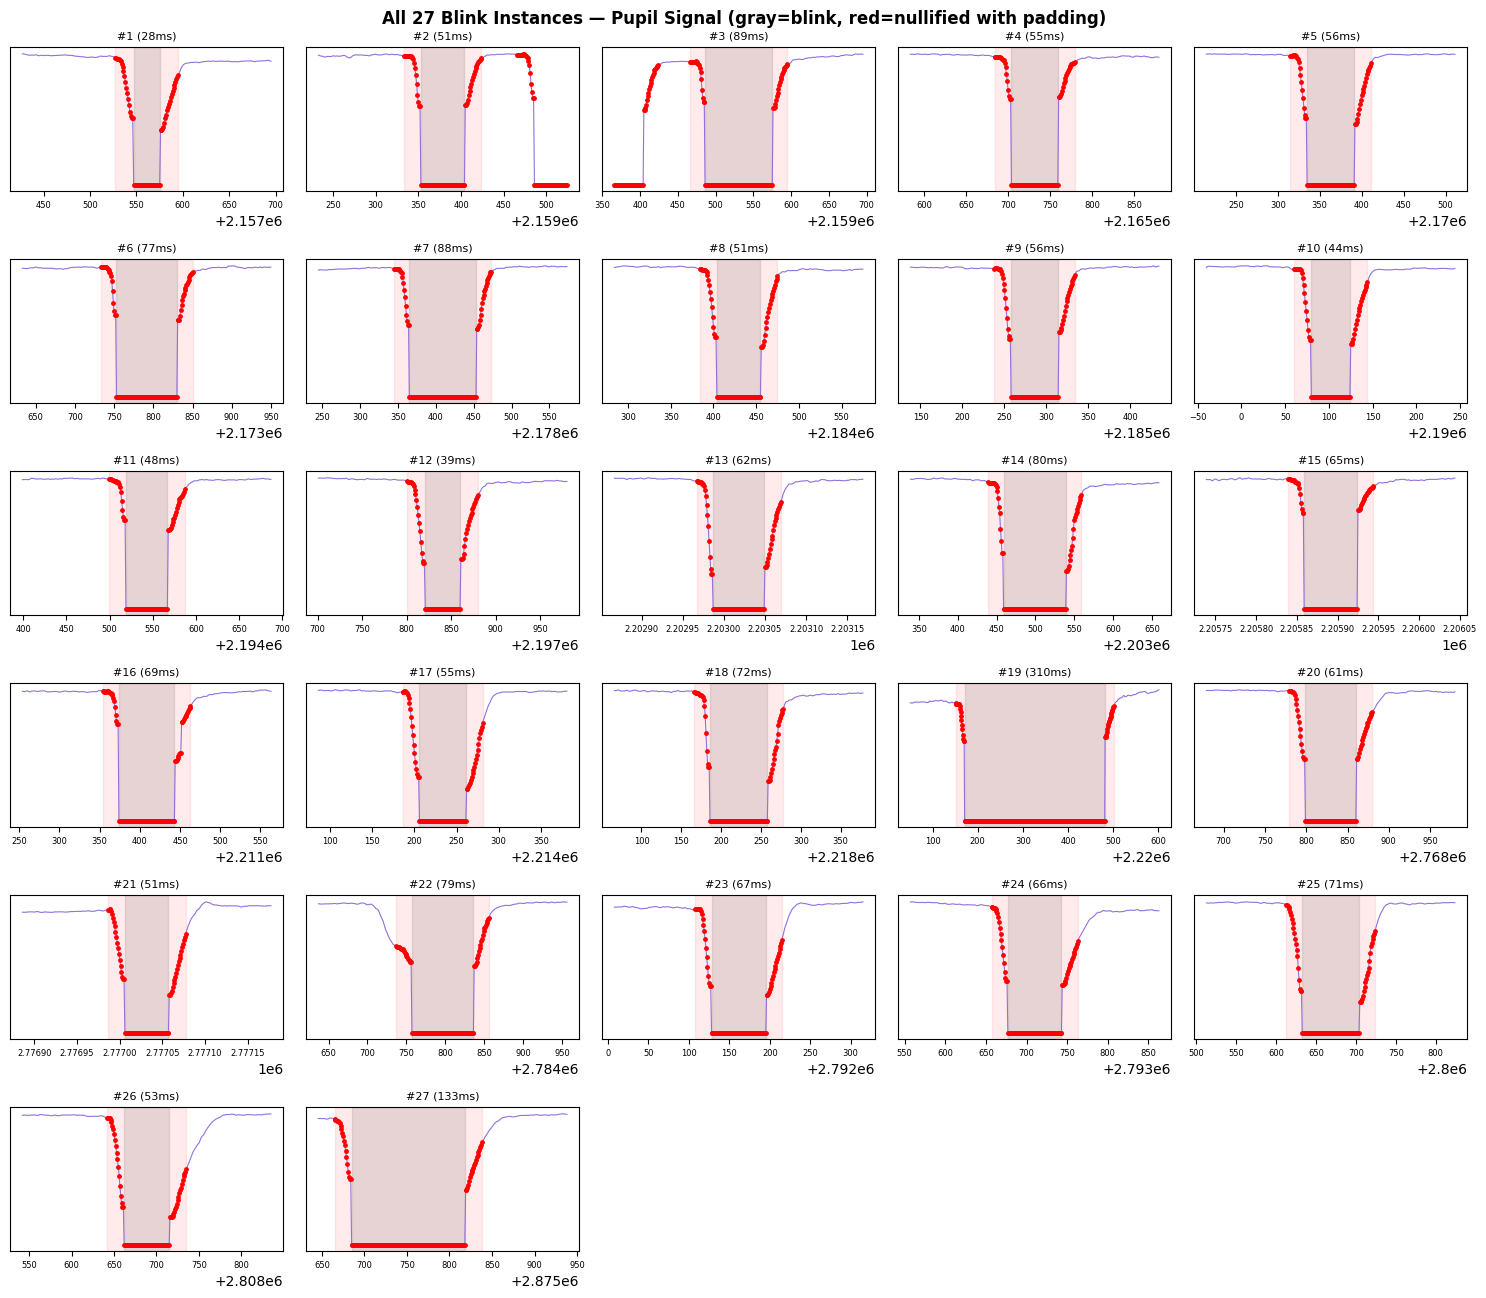

In [64]:
# Plot all blink instances in a grid: pupil signal with nullified samples in red
n = len(all_blinks)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 2.2), squeeze=False)

for idx, blink in enumerate(all_blinks):
    row, col = divmod(idx, ncols)
    ax = axes[row, col]

    t_blink = blink['time']
    pupil = blink['pupil_raw']
    nmask = blink['null_mask']

    # Plot full raw pupil trace
    ax.plot(t_blink, pupil, color='mediumpurple', linewidth=0.8)

    # Overlay nullified samples in red
    if nmask.any():
        ax.scatter(t_blink[nmask], pupil[nmask], color='red', s=6, zorder=5)

    # Shade the original blink interval in gray
    ax.axvspan(blink['onset'], blink['offset'], alpha=0.2, color='gray')

    # Shade the padded region in light red
    ax.axvspan(
        blink['onset'] - padding_all[0], blink['offset'] + padding_all[1],
        alpha=0.08, color='red',
    )

    ax.set_title(f"#{idx+1} ({blink['duration']}ms)", fontsize=8)
    ax.tick_params(labelsize=6)
    ax.set_yticks([])

# Hide unused subplots
for idx in range(n, nrows * ncols):
    row, col = divmod(idx, ncols)
    axes[row, col].set_visible(False)

fig.suptitle(
    f'All {n} Blink Instances — Pupil Signal (gray=blink, red=nullified with padding)',
    fontsize=12, fontweight='bold',
)
plt.tight_layout()
plt.show()

## Key Considerations

- **Load with `events=True`**: When using `from_asc()`, pass `events=True` to parse
  blink events from the EyeLink `SBLINK`/`EBLINK` markers. Without this flag, blink
  events are not loaded.
- **Padding values** depend on your sampling rate and how your eye tracker reports
  blink boundaries. At 1000 Hz, 20 ms = 20 samples.
- **Clean before computing derived signals** (velocity, acceleration) to prevent
  blink artifacts from propagating.
- **Asymmetric padding** `(before, after)` is recommended because blink onset
  artifacts typically extend further than offset artifacts.
- The `time` and trial columns are **never** nullified, preserving temporal alignment.
- EyeLink blink events are named `blink_eyelink`. Other eye trackers may use
  different naming conventions.